Код самой Fuzzy_Artmap со всеми необходимыми функциями

In [3]:
import numpy as np
import random

class Fuzzy_Artmap():
    def __init__(self, M = 625, choice = 0.001, learn = 0.5, vig = 0.75, st_vig = 0.75, eps = 0.001):
        #size of F-level
        self.M = M 
        #choice parameter
        self.choice=choice
        #learning parameter 
        self.learn=learn
        #changable vigilance parameter
        self.vig=vig
        #stable vigilance parameter
        self.st_vig=st_vig
        #matching parameter
        self.eps=eps
        #weights from F to C
        self.C=np.array([])
        #weights from I to F
        self.W=np.array([])
        #original data answers
        self.orig_result =np.array([])
        #size of W
        self.sz_W = np.array([])

    #complete our input
    def make_input(self, I):
        return np.concatenate((I,np.ones(I.shape) - I),axis=1)
    
    #func to calculate a^b
    def min_array(self,a,b):
        return np.array([min(a[i],b[i]) for i in range(len(a))])
    
    #func with which we select the optimal F-level vertex for our input
    def choice_function(self,x,w):
        T = sum(self.min_array(x,w))/(self.choice + sum(w))
        return T
    

    def train(self,I, I_res):
        self.M = len(I[0])
        self.orig_result=I_res
        self.C = [0]
        self.W = np.ones((1,self.M*2))
        self.sz_W = np.array([self.W.shape[0]])
        I = self.make_input(I)
           
        for index, a_i in enumerate(I):
            #just to see how fast training goes
            #if index%1000==0:
            #    print(index)

            if index==0:
                self.W[0]=a_i
                self.C[0]=self.orig_result[0];
                continue

            T_list=np.array([self.choice_function(a_i, w_i) for w_i in self.W])
            T_max = np.argmax(T_list)
            while 1:
                #if no good F-vertex found, build a new one
                if sum(T_list)==0:
                    #if self.W.shape[0]<400:
                    self.C = np.concatenate((self.C,[self.orig_result[index]]))
                    self.W = np.concatenate((self.W,[a_i]),axis=0)
                    #else:
                    #    self.C[T_max] = self.orig_result[index]
                    break

                #best matching F-vertex
                J = np.argmax(T_list)
                res = sum(self.min_array(a_i,self.W[J]))/self.M 
                if res >= self.vig:
                    if self.orig_result[index]==self.C[J]:
                        #making new weights
                        self.W[J] = self.learn*(self.min_array(a_i,self.W[J])) + (1-self.learn)*(self.W[J])
                        break
                    else:
                        T_list[J] = 0
                        #making better vig, as we failed
                        self.vig = sum(self.min_array(a_i,self.W[J]))/self.M + self.eps
                else:
                    T_list[J] = 0
            self.vig = self.st_vig
            self.sz_W = np.concatenate((self.sz_W,[self.W.shape[0]]),axis=0)

    def predict(self, input_i):
        I =self.make_input(input_i)
        ans = []
        for I_i in I:
            T_list=np.array([self.choice_function(I_i, w_i) for w_i in self.W])
            while 1:
                if sum(T_list)==0:
                    ans.append(-1)
                    break;
                J = np.argmax(T_list)
                resonance = sum(self.min_array(I_i,self.W[J]))/self.M
                if resonance >= self.vig:
                    ans.append(self.C[J])
                    break
                else:
                    T_list[J]=0
        return ans

Проверим на простых примерах, что код работает правильно.\
Во всех примерах мы, обучившись, будем считать сколько из 1000 тестов нейронная сеть будет выдавать правильный/неправильный ответ, либо говорить, что не может найти точный ответ.

1. На вход подается число Х. Нейронная сеть получаем в качестве входных данных [X%2, X%3, X%5] и должна научиться определять X%30.\
Если все сделано правильно, то из-за небольшого множества возможных входных данных, сеть должна обучиться отвечать на любой вопрос правильно.

In [3]:
A = Fuzzy_Artmap()
testing_data = np.array([[(i%2)/2, (i%3)/3, (i%5)/5] for i in range(10001)])
testing_answers = np.array([i % 30 for i in range(10001)])
A.train(testing_data, testing_answers)
test = np.array([random.randint(1,10000) for i in range(1000)])
test_predict = np.array([[(i%2)/2, (i%3)/3, (i%5)/5] for i in test])
res, sum_reson = A.predict(test_predict)
good, bad, undef = 0,0,0
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        if test[i] % 30 == res[i]:
            good += 1
        else:
            bad += 1
print("good:", good, "bad:", bad, "undef:", undef, "avg_reson:", sum_reson/1000)

good: 1000 bad: 0 undef: 0 avg_reson: 1.0


Числа k*1000 - количество sampl-ов, на которых сеть уже обучилась. Удобно, чтобы понимать скорость обучения.
Как мы можем видеть, все считается правильно.

2. На вход подается число Х. Нейронная сеть получаем в качестве входных данных [X%2, X%3, X%5, X%7, X] и должна научиться определять X%30.\
Здесь вариантов входных данных уже больше, появилось два параметра, от которых, грубо говоря, ничего не зависит. Мы хотим проверить, не испортят ли они наше обучение.

In [4]:
def results(res, test):
    good, bad, undef = 0,0,0
    for i in range(1000):
        if res[i] == -1:
            undef += 1
        else:
            if test[i] % 30 == res[i]:
                good += 1
            else:
                bad += 1
    return good, bad, undef

In [5]:
B = Fuzzy_Artmap()
testing_data = np.array([[(i%2)/2, (i%3)/3, (i%5)/5, (i%7)/7, i/10001] for i in range(10001)])
testing_answers = np.array([i % 30 for i in range(10001)])
B.train(testing_data, testing_answers)
test = np.array([random.randint(1,10000) for i in range(1000)])
test_predict = np.array([[(i%2)/2, (i%3)/3, (i%5)/5, (i%7)/7, i/10001] for i in test])
res, sum_reson = B.predict(test_predict)
good, bad, undef = results(res,test)
print("right answers:", good, "bad answers:", bad, "undefined answers:", undef)
print("average resonance:", sum_reson/1000)
print("amount of fuzzy classes:", B.W.shape[0])

right answers: 1000 bad answers: 0 undefined answers: 0
average resonance: 0.7717741859309784
amount of fuzzy classes: 129


Как мы видим, все еще 100 процентов тестов решились правильно, хотя средний параметр бдительности стал порядка 0.75. То есть в каждом результате мы "уверены" в среднем на 77 процентов, но этого оказывается достаточно.

3. На вход поступает массив из 5 элементов от 1 до 10. Мы хотим, чтобы нейросеть обучилась находить максимальный элемент массива. \
Здесь уже пространство различных входных данных огромное - 10^5 вариантов, все их мы явно не запомним. Более того, немного отличающиеся данные могут давать отличающиеся ответы. Поэтому мы рассчитываем просто на хороший процент правильный ответов.

In [6]:
def results(test_predict,res):
    good, bad, undef = 0,0,0
    for i in range(1000):
        if res[i] == -1:
            undef += 1
        else:
            for j in range(5):
                if test_predict[i][j] > test_predict[i][res[i]]:
                    bad += 1
                    break
            else:
                good += 1
    return good, bad, undef

In [7]:
C = Fuzzy_Artmap()
testing_data = np.array([[random.randint(1, 10)/10 for i in range(5)] for i in range(3001)])
testing_answers = np.array([np.argmax(testing_data[i]) for i in range(3001)])
C.train(testing_data, testing_answers)
test_predict = np.array([[random.randint(1, 10)/10 for i in range(5)] for i in range(3000)])
res, sum_reson = C.predict(test_predict)
good, bad, undef = results(test_predict, res)
print("right answers:", good, "bad answers:", bad, "undefined answers:", undef)
print("amount of fuzzy classes:", C.W.shape[0])

right answers: 899 bad answers: 101 undefined answers: 0
amount of fuzzy classes: 336


Получили в итоге примерно 90% процентов правильных ответов. Очень неплохо, все работает. Если увеличивать размер обучаемой выборки, то у меня доходило до 95 процентов, но там уже обучение происходит слишком долго.

Можно переходить к непосредственному применению нейронной сети для моей задачи.\
На сайте http://sigma.whu.edu.cn/newspage.php?q=2019_03_26_ENG я нашел датасет, который включает себя изображения ровно для проверки change detectiton алгоритмов.\
Сначала распарсим train data.\
Изначально она хранится в папках first и second в виде .tif изображений и класс картинки указан непосредственно в ее названии.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
%matplotlib inline
import os
A = imread('first/l1_n1_x2987_y3748.tif')

Изображения из датасета хранятся в виде картинок $150\times150$, каждая прнадлежит какому-то классу.\
Каждое изображение я разделил на 36 изображений $25\times25$, усреднил значение в каждом квадрате $5\times5$ и добавил получившиеся данные в соответствующий класс.

Пример одного из снимков из датасета.

18
class: 3


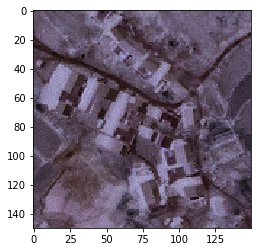

In [4]:
check = random.randint(1,200)
cnt=0
for root, dirs, files in os.walk("./first"):
    for filename in files:
        cnt+=1
        A = imread("first/" + str(filename))
        if cnt==18:
            print(cnt)
            print("class:", int(str(filename)[1]))
            _ = plt.imshow(A, cmap='gray')
            testingA=A
            testing_cl=int(str(filename)[1])

Результат разделения снимка на 36 более мелких изображенй $25\times25$ на примере того же снимка. 

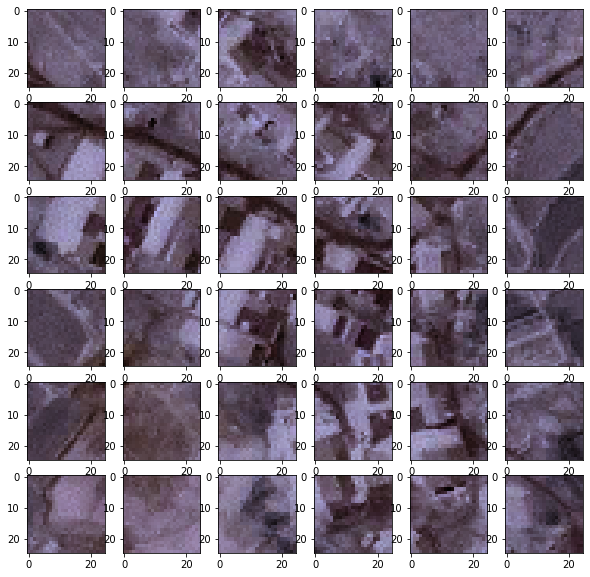

In [254]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
for i in range(6):
        for j in range(6):
            curA = testingA[25*i:25*(i+1), 25*j:25*(j+1)]
            axs[i,j].imshow(curA, cmap="gray")
    

Результат усреднения цвета в каждом маленьком квадрате на примере все того же снимка

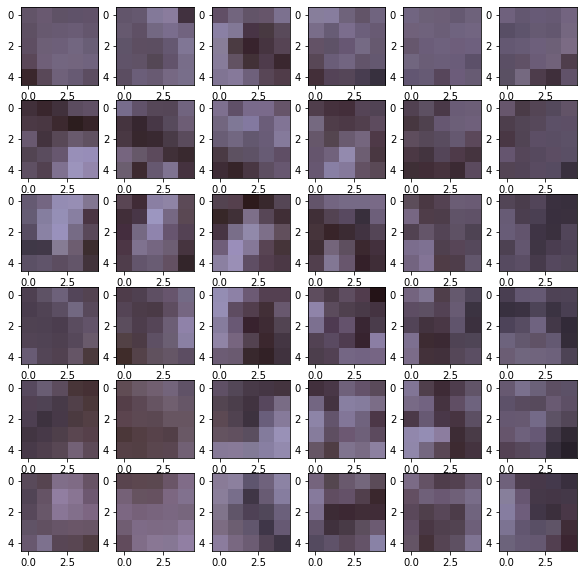

In [6]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
test_data = []
for i in range(6):
        for j in range(6):
            curA = testingA[25*i:25*(i+1), 25*j:25*(j+1)]
            resA = np.zeros((5,5,4))
            for x in range(5):
                for y in range(5):
                    for ix in range(5*x, 5*(x+1)):
                        for iy in range(5*y, 5*(y+1)):
                            resA[x][y] +=curA[ix][iy]
            resA /= (25 * 256)
            axs[i,j].imshow(resA, cmap="gray")
            test_data.append(resA)

Теперь проделаем все операции со всеми снимками из датасета

In [12]:
import random
data = [[] for i in range(8)]
for root, dirs, files in os.walk("./first"):
    for filename in files:
        cl = int(str(filename)[1]) - 1
        A = imread("first/" + str(filename))
        for i in range(6):
            for j in range(6):
                curA = A[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
                resA = np.zeros((5,5,4))
                for x in range(5):
                    for y in range(5):
                        for ix in range(5*x, 5*(x+1)):
                            for iy in range(5*y, 5*(y+1)):
                                resA[x][y] +=curA[ix][iy]
                resA /= (25*256)
                data[cl].append(resA)
for root, dirs, files in os.walk("./second"):
    for filename in files:
        cl = int(str(filename)[1]) - 1
        A = imread("second/" + str(filename))
        for i in range(6):
            for j in range(6):
                curA = A[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
                resA = np.zeros((5,5,4))
                for x in range(5):
                    for y in range(5):
                        for ix in range(5*x, 5*(x+1)):
                            for iy in range(5*y, 5*(y+1)):
                                resA[x][y] +=curA[ix][iy]
                resA /= (25 * 256)
                data[cl].append(resA)

Для каждого класса я получил вот столько картинок $5\times5$ для обучения.

In [13]:
print("amount of data per class:", [len(data[i]) for i in range(8)])
print("total amount of data:", sum([len(data[i]) for i in range(8)]))
print("one sample shape:", data[1][0].shape)

amount of data per class: [720, 2052, 936, 1836, 2016, 1908, 1800, 2412]
total amount of data: 13680
one sample shape: (5, 5, 3)


Теперь переделаем изображения в простой numpy array и добавим информацию о принадлежащем классе. 

In [8]:
resulted_data = np.zeros((13680, 76))
s=0
for cl in range(8):
    for j in data[cl]:
         resulted_data[s][:-1] = np.reshape(j, (75, ))
        resulted_data[s][-1] = cl
        s+=1

Ну и еще перемешаем, чтобы обучаться не подряд по классам, и разделить ответы от входных данных.

In [16]:
np.random.shuffle(resulted_data)
final_data = resulted_data[:,:-1]
final_data_answers = resulted_data[:, -1]
print(final_data)
print(final_data_answers)

[[0.560625   0.49078125 0.539375   ... 0.26625    0.17515625 0.21015625]
 [0.49625    0.39625    0.6053125  ... 0.505      0.398125   0.61765625]
 [0.44265625 0.3825     0.4415625  ... 0.29859375 0.22578125 0.2525    ]
 ...
 [0.26046875 0.24328125 0.2853125  ... 0.26265625 0.24953125 0.29234375]
 [0.2725     0.259375   0.31234375 ... 0.263125   0.24890625 0.29875   ]
 [0.26125    0.2471875  0.289375   ... 0.2309375  0.2109375  0.2484375 ]]
[7. 1. 7. ... 6. 6. 6.]


Выгружаем полученные данные для всей выборки на комп.

In [18]:
with open('test_data.npy', 'wb') as f:
    np.save(f, final_data)
with open('test_data_answers.npy', 'wb') as f:
    np.save(f, final_data_answers)
with open('ttest_data.npy', 'wb') as f:
    np.save(f, test_final_data)
with open('ttest_data_answers.npy', 'wb') as f:
    np.save(f, test_data_answers)

Распарсив train data, попробуем обучиться на ней.

In [19]:
A = Fuzzy_Artmap()
testing_data = np.load("./test_data.npy")
testing_answers = np.load("./test_data_answers.npy")
print(testing_data.shape, testing_answers.shape)
print(testing_data.shape)
A.train(testing_data[:2000], testing_answers[:2000])

(13680, 75) (13680,)
(13680, 75)


Проверим теперь, что все работает примерно правильно.

amount of samples: 1000
good: 482 bad: 518 undef: 0
match table:
[[  5.   0.   0.  19.  12.   3.   1.   2.]
 [  0. 138.   5.   4.   5.   0.   1.   4.]
 [  0.   0.  20.  12.   8.   3.   3.  10.]
 [  1.   0.   6.  64.  42.   8.   1.  20.]
 [  1.   0.   8.  32.  73.   4.   5.  30.]
 [  1.   0.   6.  23.  10.  58.  25.  23.]
 [  0.   0.  12.   2.  12.  15.  74.   9.]
 [  1.   0.   8.  34.  42.  31.  14.  50.]]


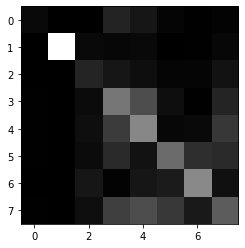

In [20]:
test_predict = testing_data[2000:3000]
res, sum_reson = A.predict(test_predict)
good, bad, undef = 0,0,0
match_array = np.zeros((8,8))
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        match_array[int(testing_answers[2000+i])][int(res[i])]+=1
        if testing_answers[2000+i] == res[i]:
            good += 1
        else:
            bad += 1
print("amount of samples: 1000")
print("good:", good, "bad:", bad, "undef:", undef)
print("match table:")
print(match_array)
_ = plt.imshow(match_array/np.max(match_array), cmap='gray')

Получилось довольно мало, но хоть какая-то точность есть. Мы однозначно видим, что нейронная сеть классифицирует картинки не каким-то случайным образом.\
Во многом, думаю, это происходит из-за того, что поделив картинку на 36 частей, у меня многие из частей на самом деле не относятся к тому классу, к которому относилась вся картинка. Но эти издержки нам необходимы, чтобы размер датасета был не очень маленьким, а входные данные не такие огромные и информативные.

Теперь давайте посмотрим, что получается, на каком-нибудь примере.

26
class: 4


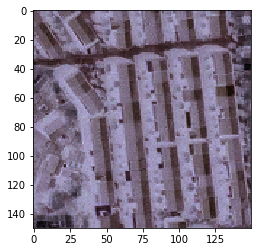

In [12]:
cnt=0
for root, dirs, files in os.walk("./first"):
    for filename in files:
        cnt+=1
        A = imread("first/" + str(filename))
        if cnt==26:
            print(cnt)
            print("class:", int(str(filename)[1]))
            _ = plt.imshow(A, cmap='gray')
            testingA=A
            testing_cl=int(str(filename)[1])

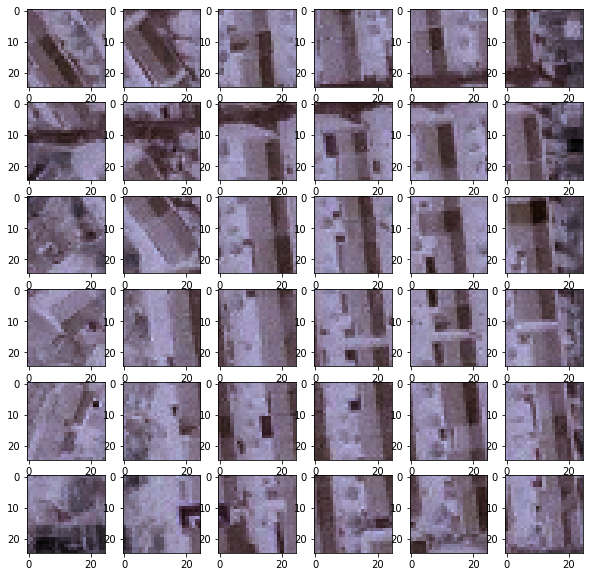

In [13]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
for i in range(6):
        for j in range(6):
            curA = testingA[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
            axs[i,j].imshow(curA, cmap="gray")

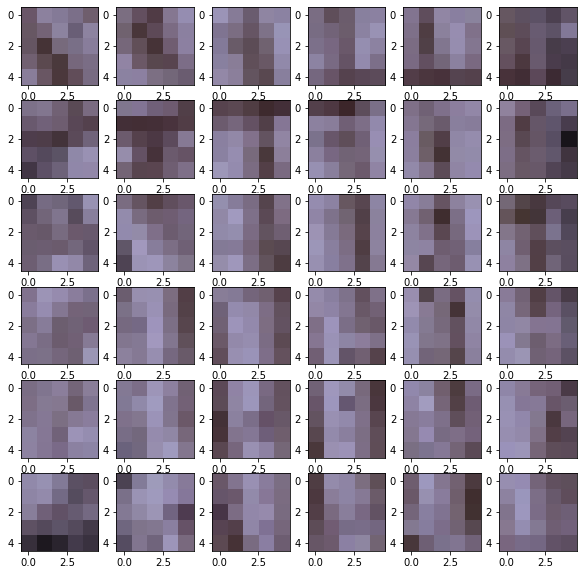

In [14]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
test_data = []
for i in range(6):
        for j in range(6):
            curA = testingA[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
            resA = np.zeros((5,5,4))
            for x in range(5):
                for y in range(5):
                    for ix in range(5*x, 5*(x+1)):
                        for iy in range(5*y, 5*(y+1)):
                            resA[x][y] +=curA[ix][iy]
            resA /= (25 * 256)
            axs[i,j].imshow(resA, cmap="gray")
            test_data.append(resA)

In [15]:
resulted_test_data = np.zeros((36, 76))
s=0
for j in test_data:
    resulted_test_data[s][:-1] = np.reshape(j, (75, ))
    resulted_test_data[s][-1] = testing_cl
    s+=1

In [16]:
test_final_data = resulted_test_data[:,:-1]
test_data_answers = resulted_test_data[:, -1]

In [28]:
with open('ttest_data.npy', 'wb') as f:
    np.save(f, test_final_data)
with open('ttest_data_answers.npy', 'wb') as f:
    np.save(f, test_data_answers)

In [252]:
A = Fuzzy_Artmap()
testing_data = np.load("./test_data.npy")
testing_answers = np.load("./test_data_answers.npy")
#print(testing_data.shape, testing_answers.shape)
#print(testing_data.shape)
A.train(testing_data[:3000], testing_answers[:3000])


Здесь также посмотрим на график количества размытых классов от размера выборки. Это даст нам представление о скорости работу обучения.

(3000,)


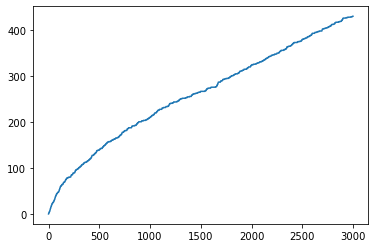

In [253]:
print(A.sz_W.shape)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.array(range(3000)), A.sz_W)
plt.show()

и наконец посмотрим на реезультаты на выбранном нами примере

In [160]:
ttesting_data = np.load("./ttest_data.npy")
ttesting_answers = np.load("./ttest_data_answers.npy")
test_predict = ttesting_data
res, sum_reson = A.predict(test_predict)
good, bad, undef = 0,0,0
match_array = np.zeros((8,8))
for i in range(36):
    if res[i] == -1:
        undef += 1
    else:
        match_array[int(ttesting_answers[i])][int(res[i])]+=1
        if ttesting_answers[i]-1 == res[i]:
            good += 1
        else:
            bad += 1
print("good:", good, "bad:", bad, "undef:", undef)
print(match_array)

good: 11 bad: 25 undef: 0
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  4. 11.  9.  0.  4.  7.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'change detection')

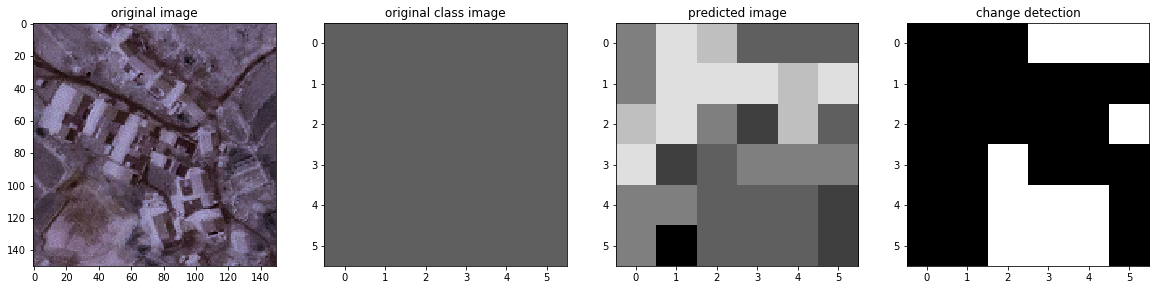

In [161]:
ans = np.zeros((6,6,4))
ans2 = np.zeros((6,6,4))
ans2+=3
change = np.zeros((6,6,4))
for i in range(6):
    for j in range(6):
        ans[i][j]=np.array([res[6*i+j],res[6*i+j],res[6*i+j] ])
        if ans[i][j][0] == ans2[i][j][0]:
            change[i][j] = np.array([1,1,1])
        else:
            change[i][j] = np.array([0,0,0])
ans/=8
ans2/=8
fig, axs = plt.subplots(1, 4, figsize=(20,20))
axs[0].imshow(testingA, cmap="gray")
axs[0].set_title("original image")
axs[1].imshow(ans2, cmap="gray")
axs[1].set_title("original class image")
axs[2].imshow(ans, cmap="gray")
axs[2].set_title("predicted image")
axs[3].imshow(change, cmap="gray")
axs[3].set_title("change detection")

Получили довольно много отличий от настоящего класса, но 11 частей все-таки совпали с тем, что должно было получиться. В то же время мы понимаем, что левый нижний угол, например, который классифицировался неправильно, скорее всего и не принадлежитт классу всей картинки

Теперь будем проверять работу алгоритма обнаружения изменений. Данные в датасете немного смещенные, то есть одинаковые местности могут незначительно отличаться, поэтому найдем пары совпадающих, написав немного кода.

In [106]:
cnt = 0
x2002, y2002 = [], []
data2002 = []
for root, dirs, files in os.walk("./first"):
    for filename in files:
        data2002.append(imread("first/" + str(filename)))
        x2002.append(filename[filename.find('x')+1:filename.find('y')-1])
        y2002.append(filename[filename.find('y')+1:filename.find('.')])
x2009, y2009 = [], []
data2009 = []
for root, dirs, files in os.walk("./second"):
    for filename in files:
        data2009.append(imread("second/" + str(filename)))
        x2009.append(filename[filename.find('x')+1:filename.find('y')-1])
        y2009.append(filename[filename.find('y')+1:filename.find('.')])
sz2002, sz2009 = len(data2002), len(data2009)

3404 3292
3404 3299


1 115
28 71
67 109
81 19
127 149
143 181
189 29


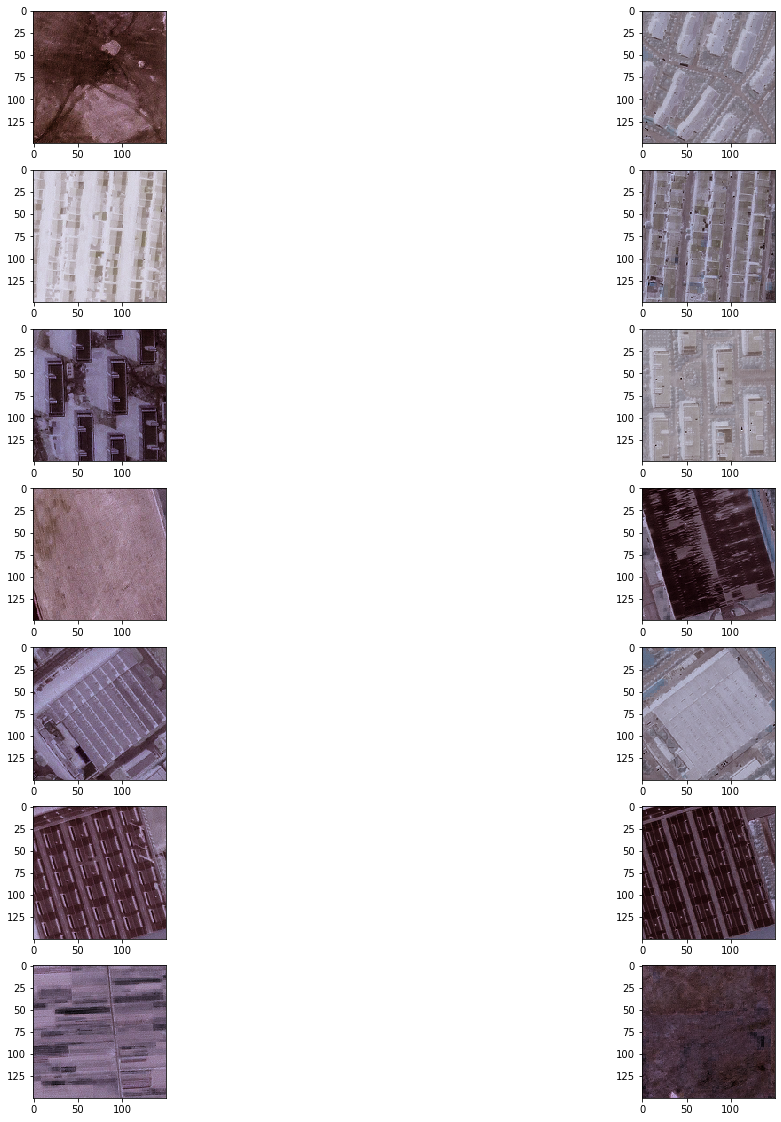

In [261]:
cnt= 0
fig, axs = plt.subplots(7, 2, figsize=(20,20))
for i in range(sz2002):
    for j in range(sz2009):
        if abs(int(x2002[i]) - int(x2009[j]))<10 and abs(int(y2002[i]) - int(y2009[j]))<10:
            print(i,j)
            axs[cnt,0].imshow(data2002[i], cmap="gray")
            axs[cnt,1].imshow(data2009[j], cmap="gray")
            cnt+=1

Так мы видим, что результаты можно проверять по парам\
127 149\
28 71\
143 181\
81 19

Для примера покажу результат на первой паре(остальные получаются поменяв входные данные в дальнейшем коде)

Text(0.5, 1.0, '2009')

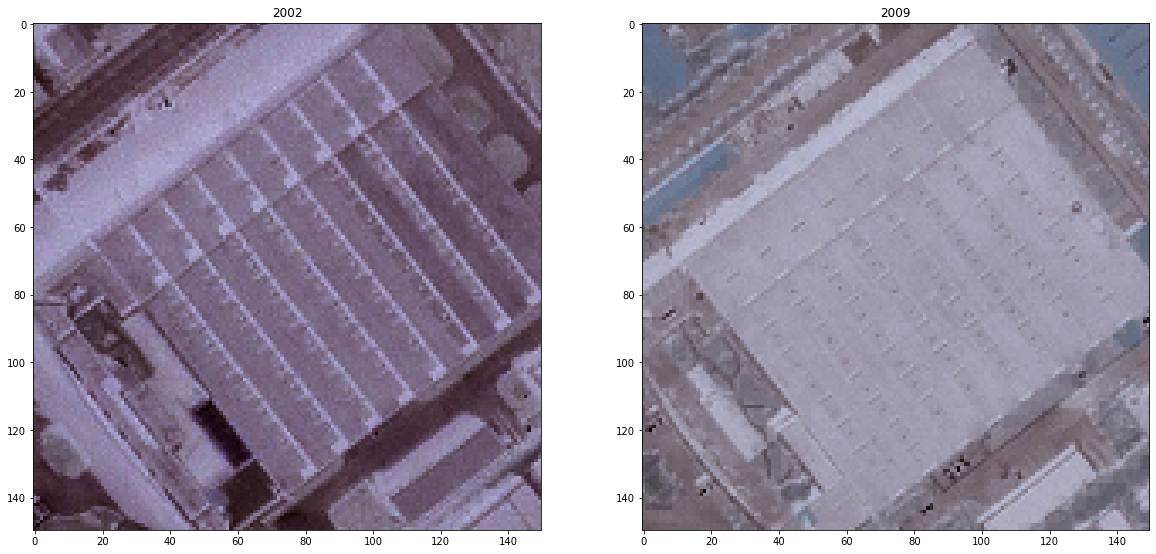

In [289]:
sample2002, sample2009 = data2002[127], data2009[149]
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].imshow(sample2002, cmap="gray")
axs[0].set_title("2002")
axs[1].imshow(sample2009, cmap="gray")
axs[1].set_title("2009")

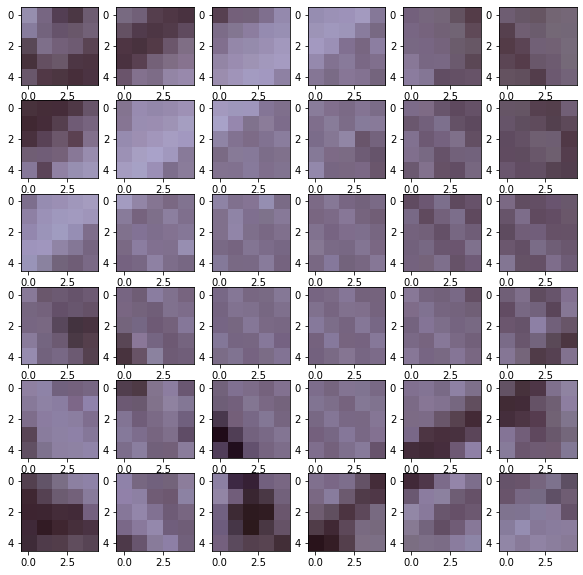

In [290]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
data_sample2002 = []
for i in range(6):
        for j in range(6):
            curA = sample2002[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
            resA = np.zeros((5,5,3))
            for x in range(5):
                for y in range(5):
                    for ix in range(5*x, 5*(x+1)):
                        for iy in range(5*y, 5*(y+1)):
                            resA[x][y] +=curA[ix][iy]
            resA /= (25 * 256)
            axs[i,j].imshow(resA, cmap="gray")
            data_sample2002.append(resA)

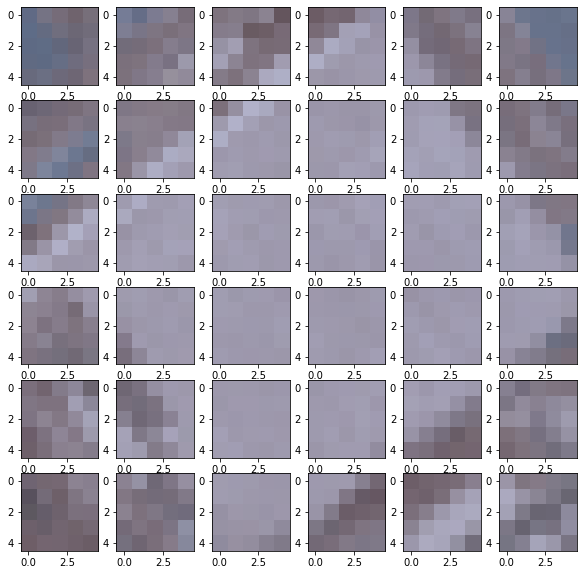

In [291]:
fig, axs = plt.subplots(6, 6, figsize=(10,10))
data_sample2009 = []
for i in range(6):
        for j in range(6):
            curA = sample2009[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
            resA = np.zeros((5,5,4))
            for x in range(5):
                for y in range(5):
                    for ix in range(5*x, 5*(x+1)):
                        for iy in range(5*y, 5*(y+1)):
                            resA[x][y] +=curA[ix][iy]
            resA /= (25 * 256)
            axs[i,j].imshow(resA, cmap="gray")
            data_sample2009.append(resA)

In [292]:
resulted_test_data2002, resulted_test_data2009 = np.zeros((36, 75)), np.zeros((36, 75))
s=0
for j in data_sample2002:
    resulted_test_data2002[s] = np.reshape(j, (75, ))
    s+=1
s=0
for j in data_sample2009:
    resulted_test_data2009[s] = np.reshape(j, (75, ))
    s+=1

with open('data2002.npy', 'wb') as f:
    np.save(f, resulted_test_data2002)
with open('data2009.npy', 'wb') as f:
    np.save(f, resulted_test_data2009)

In [293]:
ttesting_data2002 = np.load("./data2002.npy")
res2002 = A.predict(ttesting_data2002)[0]

ttesting_data2009 = np.load("./data2009.npy")
res2009 = A.predict(ttesting_data2009)[0]

Text(0.5, 1.0, 'change detection')

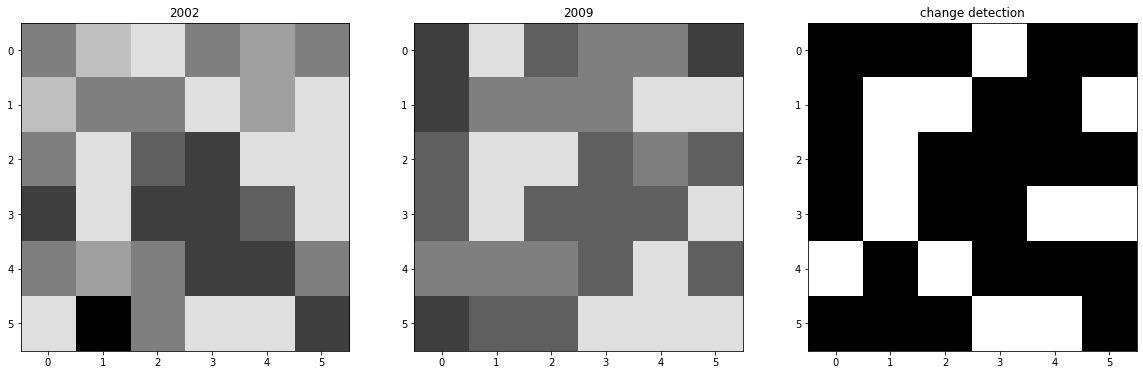

In [294]:
ans2002 = np.zeros((6,6,4))
ans2009 = np.zeros((6,6,4))
change = np.zeros((6,6,4))
for i in range(6):
    for j in range(6):
        ans2002[i,j]=np.array([res2002[6*i+j],res2002[6*i+j],res2002[6*i+j] ])
        ans2009[i,j]=np.array([res2009[6*i+j],res2009[6*i+j],res2009[6*i+j] ])
        if ans2002[i,j][0] == ans2009[i][j][0]:
            change[i,j] = np.array([1,1,1])
        else:
            change[i,j] = np.array([0,0,0])
ans2002/=8
ans2009/=8
fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(ans2002, cmap="gray")
axs[0].set_title("2002")
axs[1].imshow(ans2009, cmap="gray")
axs[1].set_title("2009")
axs[2].imshow(change, cmap="gray")
axs[2].set_title("change detection")